# Imports and data loading

In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import pandas as pd

from scvi.dataset import CellMeasurement, AnnDatasetFromAnnData, GeneExpressionDataset
from scvi.models import TOTALVI
from scvi.inference import TotalPosterior, TotalTrainer

import anndata
import scanpy as sc

from scipy.stats import pearsonr, spearmanr

from scvi import set_seed

save_path = "/data/yosef2/users/adamgayoso/projects/totalVI_journal/data/"

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import umap

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from torch.distributions import Bernoulli

@torch.no_grad()
def decode_archetypes(posterior, transform_batch = 0, include_bg=True, sample_bern=False, normalize_pro=False):
    identity = torch.eye(posterior.model.n_latent).cuda()
    batch_index = torch.ones((posterior.model.n_latent, 1)).cuda() * transform_batch
    # labels is not used, but needs to have some value
    label = batch_index
    # decode
    px_, py_, log_pro_back_mean = posterior.model.decoder(identity, 1, batch_index, label)
    protein_mixing = 1 / (1 + torch.exp(-py_["mixing"]))
    if sample_bern is True:
        protein_mixing = Bernoulli(protein_mixing).sample()
    pro_value = (1 - protein_mixing) * py_["rate_fore"]
    if include_bg is True:
        pro_value = (1 - protein_mixing) * py_["rate_fore"] + protein_mixing * py_[
            "rate_back"
        ]
    if normalize_pro is True:
        pro_value = torch.nn.functional.normalize(pro_value, p=1, dim=-1)
        
    return px_["scale"].cpu().numpy(), pro_value.cpu().numpy()

In [3]:
colors = ["#3B7EA1", "#FDB515", "#D9661F", "#859438", "#EE1F60", "#00A598"]
sns.set(context="notebook", font_scale=1.3, style="ticks")
sns.set_palette(sns.color_palette(colors))
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['savefig.transparent'] = True
plt.rcParams['figure.figsize'] = (4, 4)

sc.settings._vector_friendly = True
DPI = 300
W_SPACE = 0.18

In [4]:
set_seed(0)

In [5]:
# Load anndata
anndataset_111 = anndata.read(save_path + "spleen_lymph_111.h5ad")

# Filter out unanalyzed clusters
include_cells_111 = [
    c not in ["16,0", "17", "19", "21", "23", "24,0", "24,2", "25", "29"]
    for c in anndataset_111.obs["leiden_subclusters"]
]
anndataset_111 = anndataset_111[include_cells_111]

anndataset_206 = anndata.read(save_path + "spleen_lymph_206.h5ad")

# Filter out unanalyzed clusters
include_cells_206 = [
    c not in ["16,0", "17", "19", "21", "23", "24,0", "24,2", "25", "29"]
    for c in anndataset_206.obs["leiden_subclusters"]
]
anndataset_206 = anndataset_206[include_cells_206]

# Filter unwanted proteins (isotype controls and HTO)
keep_pro_111 = np.array(
    [not p.startswith("HTO") for p in anndataset_111.uns["protein_names"]]
)
keep_pro_206 = np.array(
    [
        not (p.startswith("HTO") or p.startswith("ADT_Isotype"))
        for p in anndataset_206.uns["protein_names"]
    ]
)

anndataset_111.obsm["protein_expression"] = anndataset_111.obsm["protein_expression"][
    :, keep_pro_111
]
anndataset_111.uns["protein_names"] = anndataset_111.uns["protein_names"][keep_pro_111]
anndataset_206.obsm["protein_expression"] = anndataset_206.obsm["protein_expression"][
    :, keep_pro_206
]
anndataset_206.uns["protein_names"] = anndataset_206.uns["protein_names"][keep_pro_206]

# Organize and instantiate scVI dataset
hvg_111 = anndataset_111.var["hvg_encode"]
hvg_206 = anndataset_206.var["hvg_encode"]

assert (hvg_111 == hvg_206).all()

anndataset_111.obs["cell_types"] = pd.Categorical([ct.replace('\n', '') for ct in  anndataset_111.obs["cell_types"]])
anndataset_206.obs["cell_types"] = pd.Categorical([ct.replace('\n', '') for ct in  anndataset_206.obs["cell_types"]])

dataset_111 = AnnDatasetFromAnnData(ad=anndataset_111[:, hvg_111])
protein_data_111 = CellMeasurement(
    name="protein_expression",
    data=anndataset_111.obsm["protein_expression"].astype(np.float32),
    columns_attr_name="protein_names",
    columns=anndataset_111.uns["protein_names"],
)
dataset_111.initialize_cell_measurement(protein_data_111)
dataset_111.gene_names = anndataset_111[:, hvg_111].var_names.values

dataset_206 = AnnDatasetFromAnnData(ad=anndataset_206[:, hvg_111])
protein_data_206 = CellMeasurement(
    name="protein_expression",
    data=anndataset_206.obsm["protein_expression"].astype(np.float32),
    columns_attr_name="protein_names",
    columns=anndataset_206.uns["protein_names"],
)
dataset_206.initialize_cell_measurement(protein_data_206)
dataset_206.gene_names = anndataset_206[:, hvg_206].var_names.values


dataset = GeneExpressionDataset()
dataset.populate_from_datasets([dataset_111, dataset_206],)

[2020-05-04 14:55:05,531] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-05-04 14:55:05,539] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-05-04 14:55:05,650] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-05-04 14:55:05,759] INFO - scvi.dataset.dataset | Downsampled from 15604 to 15604 cells
[2020-05-04 14:55:06,666] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-05-04 14:55:06,668] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-05-04 14:55:06,772] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-05-04 14:55:06,877] INFO - scvi.dataset.dataset | Downsampled from 14870 to 14870 cells
[2020-05-04 14:55:07,141] INFO - scvi.dataset.dataset | Keeping 4005 genes
[2020-05-04 14:55:07,374] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-05-04 14:55:07,547] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-

# Load model and create posterior object

In [6]:
model = TOTALVI(
    dataset.nb_genes,
    dataset.protein_expression.shape[1],
    n_latent=20,
    n_batch=dataset.n_batches,
)

In [7]:
model.load_state_dict(torch.load("../sln_all_intersect.pt"))
model.eval()

TOTALVI(
  (encoder): EncoderTOTALVI(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=4119, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Dropout(p=0.2, inplace=False)
        )
      )
    )
    (z_encoder): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
    )
    (z_mean_encoder): Linear(in_features=256, out_features=20, bias=True)
    (z_var_encoder): Linear(in_features=256, out_features=20, bias=True)
    (l_gene_encoder): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dr

In [8]:
use_cuda = True
trainer = TotalTrainer(
    model,
    dataset,
    train_size=0.90,
    test_size=0.10,
    use_cuda=use_cuda,
    frequency=1,
    data_loader_kwargs={"batch_size": 256, "pin_memory": False}
)

In [9]:
# create posterior on full data
full_posterior = trainer.create_posterior(
    model, dataset, indices=np.arange(len(dataset)), type_class=TotalPosterior
)
# extract latent space
latent_mean, batch_index, label, library_gene = full_posterior.sequential().get_latent()


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


# Number of Monte Carlo samples to average over
n_samples = 25
# Probability of background on logits scale, first dataset.nb_genes columns corresponds to ZI probability for genes
py_mixing = sigmoid(
    full_posterior.sequential().get_sample_mixing(n_samples=n_samples, give_mean=True)
)
parsed_protein_names = [p for p in dataset.protein_names]
protein_foreground_prob = pd.DataFrame(
    data=(1 - py_mixing), columns=parsed_protein_names
)
# denoised has shape n_cells by (n_input_genes + n_input_proteins) with protein features concatenated to the genes
denoised_genes, denoised_proteins = full_posterior.sequential().get_normalized_denoised_expression(
    n_samples=25, transform_batch=0
)

[ 9 11 15 17]


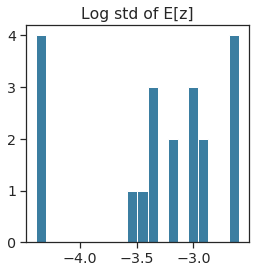

In [10]:
_ = plt.hist(np.log(np.std(latent_mean, axis=0)), bins=20)
plt.title("Log std of E[z]")
print(np.where(np.std(latent_mean, axis=0) < 0.02)[0])

In [11]:
archetype_genes, archetype_proteins = decode_archetypes(full_posterior, include_bg=False, sample_bern=True)

## Filter dead units

In [12]:
dead_units = np.where(np.std(latent_mean, axis=0) < 0.02)[0]
archetype_genes = np.delete(archetype_genes, dead_units, axis=0)
archetype_proteins = np.delete(archetype_proteins, dead_units, axis=0)

In [13]:
post_adata = anndata.AnnData(
    X=np.concatenate([denoised_genes, archetype_genes], axis=0)
)
post_adata.var.index = dataset.gene_names

temp_adata = anndata.read("../sln_all_intersect_post_adata.h5ad")
temp_adata_subset = temp_adata[include_cells_111 + include_cells_206].copy()
post_adata.obsm["X_totalVI"] = np.concatenate(
    [temp_adata_subset.obsm["X_totalVI"], np.delete(np.identity(20), dead_units, axis=0)],
    axis=0,
)
sc.pp.neighbors(post_adata, use_rep="X_totalVI", n_neighbors=30, metric="correlation")
# sc.tl.umap(post_adata, min_dist=0.3)
# um = umap.UMAP(n_neighbors=30, metric="correlation", min_dist=0.3)
# um.fit(temp_adata.obsm["X_totalVI"])

/data/yosef2/users/adamgayoso/.pyenv/versions/scvi/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../.pyenv/versions/scvi/lib/python3.7/site-packages/umap/utils.py", line 409:
@numba.njit(parallel=True)
def build_candidates(current_graph, n_vertices, n_neighbors, max_candidates, rng_state):
^

  current_graph, n_vertices, n_neighbors, max_candidates, rng_state
/data/yosef2/users/adamgayoso/.pyenv/versions/scvi/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/use

In [14]:
post_adata.obs["cell_types"] = np.concatenate(
    [
        anndataset_111.obs["cell_types"].values,
        anndataset_206.obs["cell_types"].values,
        ["Archetype"] * (20 - len(dead_units)),
    ]
)

In [15]:
j = 1
for i in range(post_adata.obsm["X_totalVI"].shape[1]):
    if i not in dead_units:
        post_adata.obs["Z_{}".format(j)] = post_adata.obsm["X_totalVI"][:, i]
        temp_adata_subset.obs["Z_{}".format(j)] = temp_adata_subset.obsm["X_totalVI"][:, i]
        j += 1

In [16]:
titles = [r"$Z_{{{ind}}}$".format(ind = i + 1) for i in range(20 - len(dead_units))]

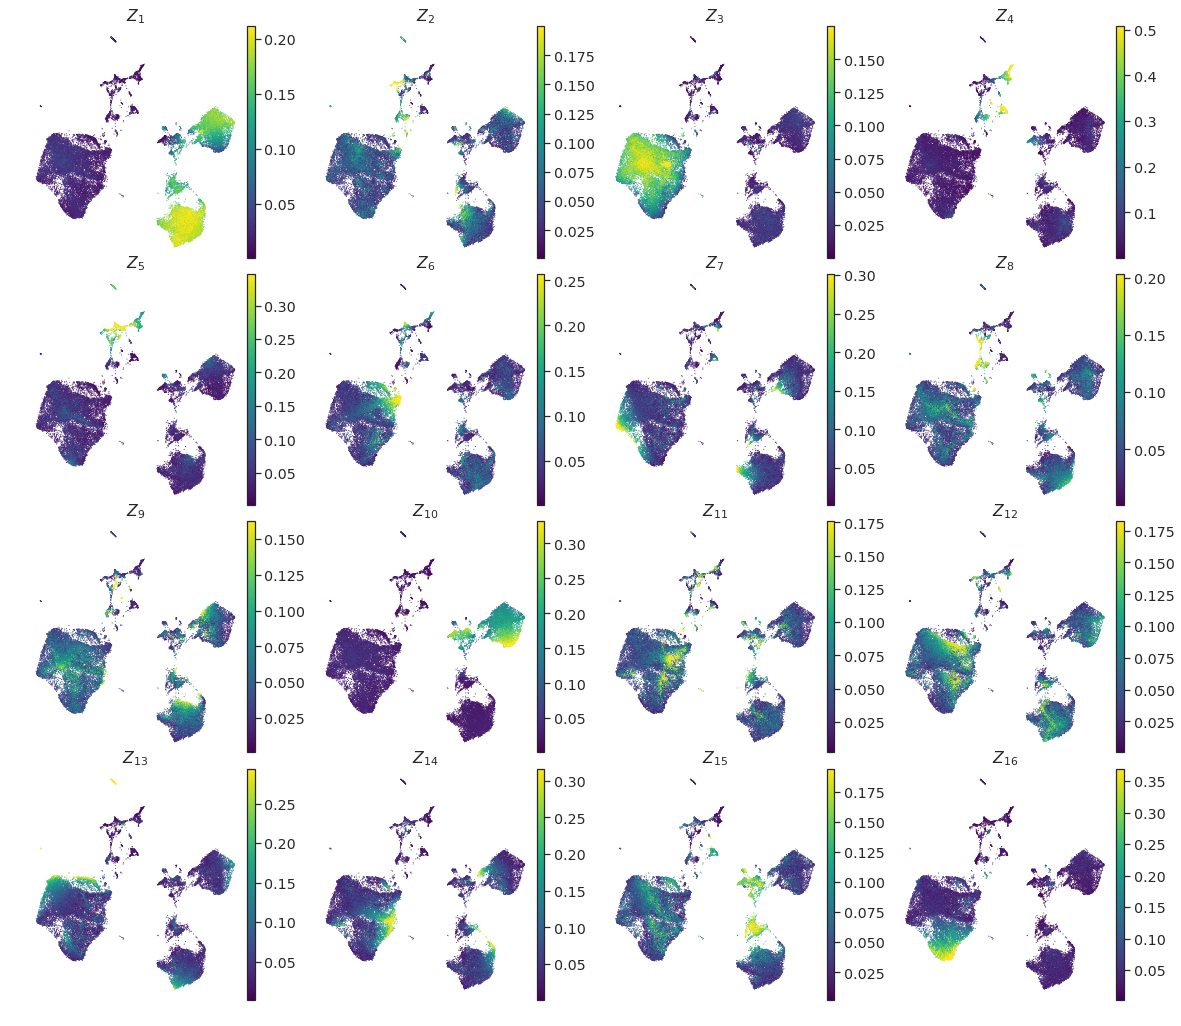

In [17]:
fig = sc.pl.umap(
    temp_adata_subset, 
    color=["Z_{}".format(i + 1) for i in range(20 - len(dead_units))],
    frameon=False,
    title=titles,
    ncols=4,
    cmap=plt.cm.viridis,
    hspace=0.07,
    return_fig=True,
    vmax="p99.5"
)
fig.savefig("figures/arch_umap_grid.pdf", dpi=DPI, bbox_inches='tight')

# Distance to archetypes

In [18]:
pro_exp = np.concatenate([denoised_proteins, archetype_proteins], axis=0)
for i in range(dataset.protein_expression.shape[1]):
    post_adata.obs["{}".format(dataset.protein_names[i].split("_")[1].split("(")[0])] = pro_exp[:, i]

In [19]:
import matplotlib.colors as mcolors

In [20]:
def plot_arch_dist(pro_feature, dimension, cell_type=None, save_fig=False):
    with sns.axes_style("ticks"):
        fig, ax = plt.subplots(figsize=(4, 4))
        # ax.hist2d(
        #     1 - post_adata.obs[dimension],
        #     post_adata.obs[pro_feature],
        #     bins=256,
        #     norm=mcolors.PowerNorm(0.10),
        #     cmap=plt.cm.gray_r,
        #     rasterized=True,
        # )
        dim_num = int(dimension.split("_")[1]) - 1

        dist_to_arch = np.sum(
            np.abs(
                post_adata.obsm["X_totalVI"][-(16 - dim_num)] - post_adata.obsm["X_totalVI"]
            ),
            axis=1,
        )
        dist_to_arch = (dist_to_arch - np.min(dist_to_arch)) / np.max(dist_to_arch)
        post_adata.obs["dist_to_arch"] = dist_to_arch

        if cell_type is not None:
            ax.scatter(
                #             1 - post_adata[post_adata.obs["cell_types"] == cell_type].obs[dimension].values[:-16],
                post_adata[post_adata.obs["cell_types"] == cell_type]
                .obs["dist_to_arch"]
                .values[:-16],
                post_adata[post_adata.obs["cell_types"] == cell_type]
                .obs[pro_feature]
                .values[:-16],
                c="#859438",
                rasterized=True,
                s=0.5,
                label=cell_type,
                zorder=1,
                alpha=0.7,
            )

        ax.scatter(
            #         1 - post_adata.obs[dimension].values[:-16],
            post_adata.obs["dist_to_arch"].values[:-16],
            post_adata.obs[pro_feature].values[:-16],
            c="grey",
            rasterized=True,
            s=0.5,
            label="Rest",
            zorder=0,
        )

        ax.scatter(
            1 - post_adata.obs[dimension].values[-(16 - dim_num)],
            post_adata.obs[pro_feature].values[-(16 - dim_num)],
            s=220,
            c="#3B7EA1",
        )
        ax.text(
            1 - post_adata.obs[dimension].values[-(16 - dim_num)],
            post_adata.obs[pro_feature].values[-(16 - dim_num)],
            dim_num + 1,
            horizontalalignment="center",
            verticalalignment="center",
            fontsize=12,
            color="white",
        )
        # ax.set_xlim(-0.1, 1.1)
        # ax.set_ylim(-3, 60)
        if cell_type is not None:
            ax.legend(markerscale=8, prop={"size": 10})
        ax.set_xlabel("Distance to archetype {}".format(dim_num + 1))
        ax.set_ylabel("totalVI expression")
        ax.set_title(pro_feature)
        sns.despine()

        if save_fig is True:
            fig.savefig(
                "figures/{}_dist_to_arch.pdf".format(pro_feature),
                bbox_inches="tight",
                dpi=DPI,
            )

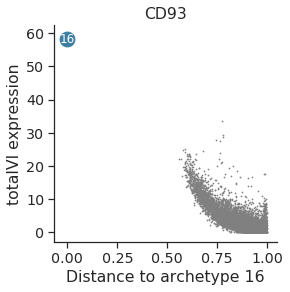

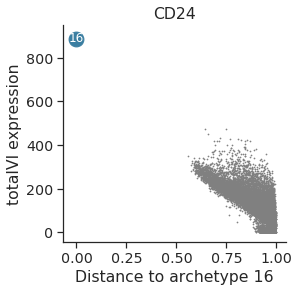

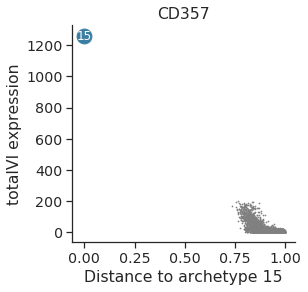

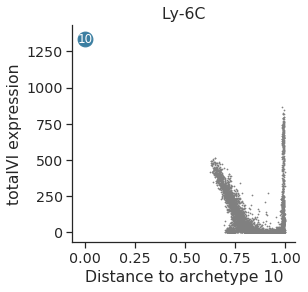

In [21]:
pro_feature = "CD93"
dimension = "Z_16"
# plot_arch_dist(pro_feature, dimension, cell_type="Transitional B", save_fig=True)
plot_arch_dist(pro_feature, dimension, save_fig=True)

pro_feature = "CD24"
dimension = "Z_16"
# plot_arch_dist(pro_feature, dimension, cell_type="Transitional B", save_fig=True)
plot_arch_dist(pro_feature, dimension, save_fig=True)


pro_feature = "CD357"
dimension = "Z_15"
plot_arch_dist(pro_feature, dimension)

pro_feature = "Ly-6C"
dimension = "Z_10"
plot_arch_dist(pro_feature, dimension)

In [22]:
def plot_arch_dist_gene(gene_feature, dimension, cell_type=None, save_fig=False):
    with sns.axes_style("ticks"):

        fig, ax = plt.subplots(figsize=(4, 4))

        dim_num = int(dimension.split("_")[1]) - 1

        dist_to_arch = np.sum(
            np.abs(
                post_adata.obsm["X_totalVI"][-(16 - dim_num)] - post_adata.obsm["X_totalVI"]
            ),
            axis=1,
        )
        dist_to_arch = (dist_to_arch - np.min(dist_to_arch)) / np.max(dist_to_arch)
        post_adata.obs["dist_to_arch"] = dist_to_arch

        if cell_type is not None:
            if cell_type == "Ifit3-high":
                label = "Ifit3-high B, T"
            else:
                label = cell_type
            ax.scatter(
                #             1 - post_adata[post_adata.obs["cell_types"] == cell_type].obs[dimension].values[:-16],
                post_adata[post_adata.obs["cell_types"] == cell_type]
                .obs["dist_to_arch"]
                .values[:-16],
                post_adata[post_adata.obs["cell_types"] == cell_type][
                    :, gene_feature
                ].X.ravel()[:-16],
                c="#859438",
                rasterized=True,
                s=0.5,
                label=label,
                zorder=1,
                alpha=0.7,
            )

        ax.scatter(
            #         1 - post_adata.obs[dimension].values[:-16],
            post_adata.obs["dist_to_arch"].values[:-16],
            post_adata[:, gene_feature].X.ravel()[:-16],
            c="grey",
            rasterized=True,
            s=0.5,
            zorder=0,
            label="Rest",
        )

        ax.scatter(
            1 - post_adata.obs[dimension].values[-(16 - dim_num)],
            post_adata[:, gene_feature].X.ravel()[-(16 - dim_num)],
            s=220,
            c="#3B7EA1",
        )
        ax.text(
            1 - post_adata.obs[dimension].values[-(16 - dim_num)],
            post_adata[:, gene_feature].X.ravel()[-(16 - dim_num)],
            dim_num + 1,
            horizontalalignment="center",
            verticalalignment="center",
            fontsize=12,
            color="white",
        )
        if cell_type is not None:
            ax.legend(markerscale=8, prop={"size": 10})
        ax.set_xlabel("Distance to archetype {}".format(dim_num + 1))
        ax.set_ylabel("totalVI expression")
        ax.set_title(gene_feature)
        sns.despine()

        if save_fig is True:
            fig.savefig(
                "figures/{}_dist_to_arch.pdf".format(gene_feature),
                bbox_inches="tight",
                dpi=DPI,
            )

In [23]:
np.unique(post_adata.obs.cell_types)

array(['Activated CD4 T', 'Archetype', 'B1 B', 'CD122+ CD8 T', 'CD4 T',
       'CD8 T', 'Erythrocytes', 'GD T', 'ICOS-high Tregs', 'Ifit3-high B',
       'Ifit3-high CD4 T', 'Ifit3-high CD8 T', 'Ly6-high mono',
       'Ly6-low mono', 'MZ B', 'MZ/Marco-high macrophages', 'Mature B',
       'Migratory DCs', 'NK', 'NKT', 'Neutrophils', 'Plasma B',
       'Red-pulp macrophages', 'Transitional B', 'Tregs', 'cDC1s',
       'cDC2s', 'pDCs'], dtype=object)

In [24]:
post_adata.obs.cell_types[post_adata.obs.cell_types == "Ifit3-high B"] = "Ifit3-high"
post_adata.obs.cell_types[post_adata.obs.cell_types == "Ifit3-high CD8 T"] = "Ifit3-high"
post_adata.obs.cell_types[post_adata.obs.cell_types == "Ifit3-high CD4 T"] = "Ifit3-high"

/data/yosef2/users/adamgayoso/.pyenv/versions/scvi/lib/python3.7/site-packages/ipykernel-5.1.2-py3.7.egg/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/data/yosef2/users/adamgayoso/.pyenv/versions/scvi/lib/python3.7/site-packages/ipykernel-5.1.2-py3.7.egg/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/data/yosef2/users/adamgayoso/.pyenv/versions/scvi/lib/python3.7/site-packages/ipykernel-5.1.2-py3.7.egg/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See t

/data/yosef2/users/adamgayoso/.pyenv/versions/scvi/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


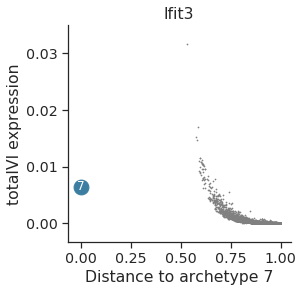

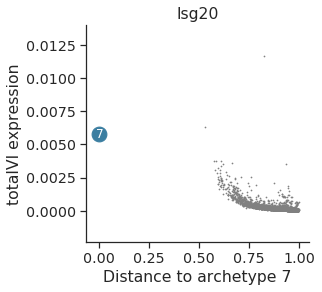

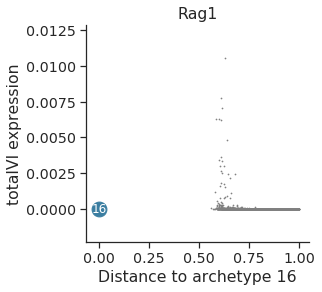

In [25]:
# plot_arch_dist_gene("Ifit3", "Z_7", cell_type="Ifit3-high", save_fig=True)
plot_arch_dist_gene("Ifit3", "Z_7", save_fig=True)

# plot_arch_dist_gene("Isg20", "Z_7", cell_type="Ifit3-high", save_fig=True)
plot_arch_dist_gene("Isg20", "Z_7", save_fig=True)

plot_arch_dist_gene("Rag1", "Z_16", save_fig=True)


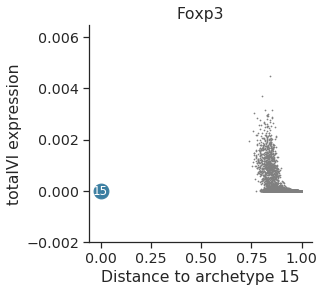

In [26]:
plot_arch_dist_gene("Foxp3", "Z_15", save_fig=True)


# Signatures

In [27]:
N_ARCHS = 20 - len(dead_units)

In [28]:
def get_percentiles_archs(arr, n_archs):
    pcts = np.argsort(np.argsort(arr, axis=0), axis=0) * 100. / (len(arr) - 1)
    return pcts[-n_archs:]

def archs_z_scores(arr, n_archs):
    mean = np.mean(arr[:-n_archs], axis=0)
    std = np.std(arr[:-n_archs], axis=0)
    archs = arr[-n_archs:]
    return (archs - mean) / std

In [29]:
# ranked_archs_genes = get_percentiles_archs(post_adata.X, N_ARCHS)
# ranked_archs_proteins = get_percentiles_archs(pro_exp, N_ARCHS)

In [30]:
z_archs_genes = archs_z_scores(post_adata.X, N_ARCHS)
z_archs_proteins = archs_z_scores(pro_exp, N_ARCHS)

In [31]:
archetypal_genes = []
top_genes = dataset.gene_names[np.argsort(z_archs_genes, axis=1)]
for i in range(top_genes.shape[0]):
    [archetypal_genes.append(s) for s in top_genes[i, -3:]]

In [32]:
archetypal_proteins = []
top_pros = dataset.protein_names[np.argsort(z_archs_proteins, axis=1)]
for i in range(top_pros.shape[0]):
    [archetypal_proteins.append(s.split("_")[1].split("(")[0]) for s in top_pros[i, -3:]]

In [33]:
p_names = [s.split("_")[1].split("(")[0] for s in dataset.protein_names]
arche_pro_df = pd.DataFrame(
    data=z_archs_proteins,
    index=["Archetype {}".format(i + 1) for i in range(z_archs_proteins.shape[0])],
    columns=p_names
)
arche_gene_df = pd.DataFrame(
    data=z_archs_genes,
    index=["Archetype {}".format(i + 1) for i in range(z_archs_genes.shape[0])],
    columns=dataset.gene_names
)

In [34]:
arche_gene_df.iloc[-2, :].sort_values(ascending=False)

Prdm1      52180.554688
Cd200r1      164.579910
Nav2          26.422100
Gypa          -0.022687
Gata2         -0.026300
               ...     
Chchd2        -6.190382
Cops2         -6.306458
Zcchc17       -6.369300
Hcfc1         -6.566785
Acp1          -6.690046
Name: Archetype 15, Length: 4005, dtype: float32

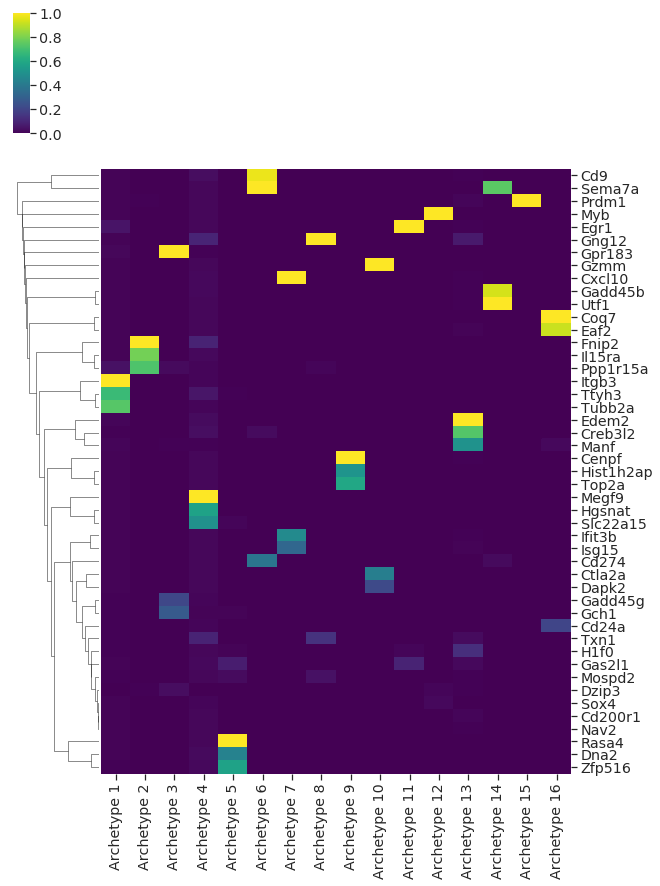

In [35]:
sns.clustermap(
    arche_gene_df.loc[:, np.unique(archetypal_genes)].T,
    standard_scale=1,
    col_cluster=False,
    cmap="viridis",
    yticklabels=True,
    figsize=(10, 14)
)
plt.savefig("figures/archetype_gene_clustermap.pdf", bbox_inches="tight")

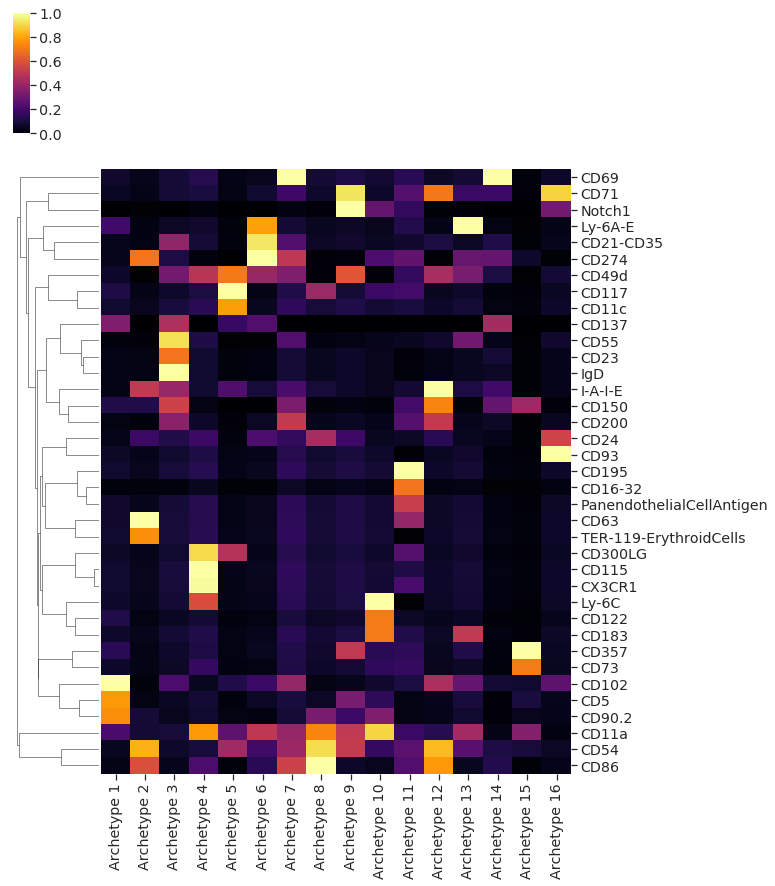

In [36]:
sns.clustermap(
    arche_pro_df.loc[:, np.unique(archetypal_proteins)].T,
    standard_scale=1,
    col_cluster=False,
    cmap="inferno",
    yticklabels=True,
    figsize=(10, 14)
)
plt.savefig("figures/archetype_protein_clustermap.pdf", bbox_inches="tight")

In [37]:
np.sort((dataset.protein_expression > 0).sum(axis=0) / len(dataset))

array([0.26711295, 0.31590864, 0.31689309, 0.36444182, 0.38737941,
       0.44805408, 0.48460983, 0.52838485, 0.56717202, 0.67480475,
       0.73662795, 0.78309378, 0.79300387, 0.79877929, 0.80557196,
       0.8063267 , 0.8257531 , 0.82650784, 0.82992059, 0.83293956,
       0.8562381 , 0.85709129, 0.86227604, 0.87077509, 0.8738925 ,
       0.87894599, 0.88094769, 0.88616526, 0.888692  , 0.89715823,
       0.89745357, 0.90299928, 0.90634639, 0.91455011, 0.9220319 ,
       0.92213034, 0.9297762 , 0.93062939, 0.93128569, 0.93427184,
       0.93735643, 0.93801273, 0.94145829, 0.94598674, 0.94628208,
       0.95107305, 0.95192623, 0.95192623, 0.95359979, 0.95527335,
       0.95579839, 0.95694691, 0.95717661, 0.95734068, 0.95855483,
       0.96035965, 0.96259106, 0.9646584 , 0.9648881 , 0.97558575,
       0.97604515, 0.97742338, 0.97778434, 0.9788016 , 0.98237842,
       0.98490517, 0.98549583, 0.98605369, 0.98618494, 0.98707095,
       0.98743191, 0.99008991, 0.99097591, 0.99356829, 0.99409

In [38]:
np.sort(z_archs_proteins[15])[-10:]

array([ 2.4734247,  2.6773555,  3.7359853,  3.7812817,  4.2873936,
        4.576353 ,  5.446217 , 10.940482 , 18.759487 , 21.226797 ],
      dtype=float32)

In [39]:
np.sort(z_archs_genes[15])[-40:]

array([ 13.623112,  14.025796,  15.319187,  16.42713 ,  16.636473,
        17.063316,  17.283453,  17.53148 ,  17.537968,  17.54502 ,
        18.446169,  18.812817,  19.681004,  19.967222,  24.677124,
        24.746471,  26.55922 ,  26.924242,  27.917906,  32.49658 ,
        34.467453,  34.85578 ,  42.483173,  43.901993,  44.558342,
        46.279736,  49.784054,  50.95082 ,  55.640285,  58.824757,
        70.834015,  75.055   ,  78.25774 , 111.447235, 122.144844,
       155.99376 , 164.62651 , 184.95291 , 832.4417  , 904.4663  ],
      dtype=float32)

In [40]:
arche_pro_df_cols = arche_pro_df.columns
arche_pro_df_cols = ["ADT_" + c for c in arche_pro_df_cols]
temp_pro_arche_df = arche_pro_df.copy()
temp_pro_arche_df.columns = arche_pro_df_cols

In [41]:
genes_pros_df = pd.concat([arche_gene_df, temp_pro_arche_df], axis=1)


In [42]:
from scipy.stats import hypergeom

cutoff = 2
pct_proteins_in_top = []
features_per_arch = []
p_vals = []

total_genes = len(dataset.gene_names)
total_proteins = len(dataset.protein_names)
pct_proteins = total_proteins / total_genes

for a in range(len(genes_pros_df)):
    arch = genes_pros_df.iloc[a, :].sort_values(ascending=False)
    features = arch[arch > cutoff].index
    features_per_arch.append(arch[arch > cutoff])
    n_proteins = 0
    for f in features:
        if f.startswith("ADT"):
            n_proteins += 1
    hyper_p = hypergeom.sf(n_proteins, total_genes + total_proteins, total_proteins, len(features))
    p_vals.append(hyper_p)
    pct_proteins_in_top.append(n_proteins / len(features))

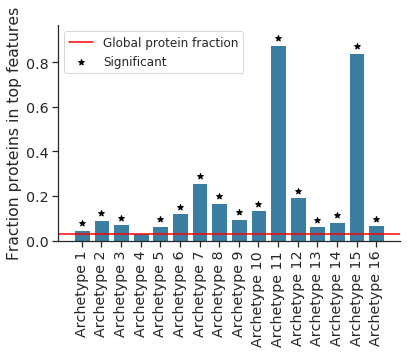

In [43]:
fig, ax = plt.subplots(figsize=(6, 5))
ax.bar(genes_pros_df.index, pct_proteins_in_top)
plt.xticks(rotation=90)
ax.axhline(pct_proteins, c="red", label="Global protein fraction")
sns.despine()
for i, p in enumerate(p_vals):
    if p < 0.05:
        plt.scatter(i, pct_proteins_in_top[i] + 0.03, marker="*", c="black")
plt.scatter([], [], label="Significant", c="black", marker="*")
ax.legend(prop={'size': 12})
ax.set_ylabel("Fraction proteins in top features")
plt.tight_layout()
fig.savefig("figures/top_proteins.pdf")